<a href="https://colab.research.google.com/github/DeependraChaddha/Heat_Equation_Solver/blob/main/Heat_Equation_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Using Gradient Descent to solve heat equation.
The difference between LHS and RHS of Heat Equation is used as Loss function.
Will experiment with optimizers to see which works best

#Make imports

In [71]:
import torch
from torch import nn
import numpy as np
import random
from torch import Tensor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import time
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image

#Device-Agnostic Code

In [56]:
device='cuda' if torch.cuda.is_available() else 'cpu'

Set random seeds

In [57]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch CUDA (Single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA (All GPUs)

    # Ensures deterministic behavior in GPU operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Can slow down training but ensures reproducibility

# Call this at the beginning of your script
set_seed(42)

#Specifying equation and coordinate system

Will figure out how to solve for first example, will then functionalize and implement on example 2 and 3. Example 4 is time dependent so may have to use different approach for that

##Example 1
∂²T/∂x² + ∂²T/∂y² = 8π²sin(2πx)sin(2πy)

T(0,y) = 0
T(1,y) = 0
T(x,0) = 0
T(x,1) = 0


Take x=0,x=1, y=0,y=1 as edges because of the initial conditions

In [58]:
#Specify number of points in grid in each direction
#todo assert both nx,ny to be strictly greater than 1 when generalizing
nx=1000
ny=1000

#calculate spacing between 2 points in the grid
lx=1/(nx-1)
ly=1/(ny-1)

Make grid

In [59]:
#Make linear space of x and y and reshape to the shape(nx,1) and (ny,1) respectively (Reshaping is done so that in case of matrix multiplication or broadcasting no error is encountered)
x=torch.linspace(0,1,nx).reshape(-1,1).requires_grad_(True)
y=torch.linspace(0,1,ny).reshape(-1,1).requires_grad_(True)

#Make meshgrid
X,Y=torch.meshgrid(x.squeeze(),y.squeeze(),indexing='ij')
X.reshape(-1,1).requires_grad_(True)
Y.reshape(-1,1).requires_grad_(True)
print(X.shape)
print(Y.shape)

torch.Size([1000, 1000])
torch.Size([1000, 1000])


In [60]:
#To get (i,j) point
i=3
j=4
print(f'(i,j)th point is {X[i,j]},{Y[i,j]}')

(i,j)th point is 0.0030030030757188797,0.004004003945738077


###Make PINN to find solution of Heat Equation







In [61]:
class SolutionFunction(nn.Module):
  def __init__(self):
    set_seed()
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(2,10),
        nn.Tanh(),
        nn.Linear(10,10),
        nn.Tanh(),
        nn.Linear(10,10),
        nn.Tanh(),
        nn.Linear(10,1)
    )

  def forward(self,X,Y,nx,ny):
      #reshape before concatenation to get correct dimension
      X=X.reshape(-1,1)
      Y=Y.reshape(-1,1)
      return self.layers(torch.cat((X,Y),dim=1)).reshape(nx,ny)

#check if it works properly
demo_model=SolutionFunction()
demo_model(X,Y,nx,ny)

tensor([[0.3230, 0.3229, 0.3228,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3229, 0.3229,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3230, 0.3229,  ..., 0.2529, 0.2528, 0.2527],
        ...,
        [0.3587, 0.3586, 0.3585,  ..., 0.2845, 0.2844, 0.2843],
        [0.3587, 0.3586, 0.3586,  ..., 0.2845, 0.2844, 0.2844],
        [0.3588, 0.3587, 0.3586,  ..., 0.2845, 0.2845, 0.2844]],
       grad_fn=<ViewBackward0>)

In [62]:
demo_model(X,Y,nx,ny).shape[-1]

1000

Constructing loss functions

In [63]:
def pde_loss(model:nn.Module,
             x:torch.Tensor,
             y:torch.Tensor,
             nx:int,
             ny:int):
  '''
  calculates loss according to the heat equation
  Inputs:
  Model:the neural network being trained
  x,y: x,y direction coordinates of meshgrid

  Output: Value of loss according to heat equation
  '''

  x.requires_grad_(True)
  y.requires_grad_(True)

  #calculate meshgrid
  f=model(X,Y,nx,ny)

  #Calculate gradients
  f_x=torch.autograd.grad(f,x,torch.ones_like(f),create_graph=True)[0]
  f_y=torch.autograd.grad(f,y,torch.ones_like(f),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=8*np.pi**2*torch.sin(2*np.pi*x)*torch.sin(2*np.pi*y)

  #Calculate loss
  loss=torch.mean((f_xx+f_yy-target)**2)

  return loss




def boundary_loss(model:nn.Module,
                  x:torch.Tensor,
                  y:torch.Tensor,
                  nx:int,
                  ny:int):
  ''' Input: the gird coordinates and model
      Output:Boundary Loss Value
      loss is defined for a specific boundary condition will have to change function depending on the problem, it is NOT a generally usable function
  '''
  x.requires_grad_(True)
  y.requires_grad_(True)

  #calculate meshgrid
  f=model(X,Y,nx,ny)

  #get loss
  loss=(f[0,:]-torch.zeros(f.shape[-1]))**2+ (f[-1,:]-torch.zeros(f.shape[-1]))**2+ (f[:,0]-torch.zeros(f.shape[-1]))**2+ (f[:,-1]-torch.zeros(f.shape[-1]))**2

  # return loss
  return torch.mean(loss)






def total_loss(model:nn.Module,
               x:torch.Tensor,
               y:torch.Tensor,
               nx:int,
               ny:int,
               boundary_loss_weight:float=100.0):
  '''Combining both loss functions using a specific weight to measure relative importance of the 2 losses'''
  return pde_loss(model,x,y,nx,ny)+boundary_loss_weight*boundary_loss(model,x,y,nx,ny)

test loss function

In [64]:
loss=total_loss(demo_model,X,Y,nx,ny)
print(loss)

tensor(1592.7068, grad_fn=<AddBackward0>)


Set Optimizer and Train


In [65]:
#Try plotting after every few steps to visualize the training process
#Initialize Model
model=SolutionFunction()
print(model(X,Y,nx,ny))
#Set SGD Optimizer
sgd_optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

#Set ADAM Optimizer
adam_optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

tensor([[0.3230, 0.3229, 0.3228,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3229, 0.3229,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3230, 0.3229,  ..., 0.2529, 0.2528, 0.2527],
        ...,
        [0.3587, 0.3586, 0.3585,  ..., 0.2845, 0.2844, 0.2843],
        [0.3587, 0.3586, 0.3586,  ..., 0.2845, 0.2844, 0.2844],
        [0.3588, 0.3587, 0.3586,  ..., 0.2845, 0.2845, 0.2844]],
       grad_fn=<ViewBackward0>)


Make a plotting function to visualize training

In [81]:
def plot_solution(frames:list):

  #Animate collected frames
  def update(frame_idx):
    X_np, Y_np, Z_np, epoch=frames[frame_idx]
    ax.clear()
    ax.plot_surface(X_np, Y_np, Z_np, cmap='viridis')
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("T")
    ax.set_title(f"Epoch: {epoch+1}")
  #Create Animation
  ani=FuncAnimation(fig, update,frames=len(frames),interval=500)

  return ani

Make Training Loop

In [82]:
# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

epochs=10
frames=[]
loss_values=[]

#disable interactive mode before training
plt.ioff()

for epoch in range(epochs):
  #Send data to selected device
  X.to(device)
  Y.to(device)


  #Forward Pass
  prediction=model(X,Y,nx,ny)

  #Calculate Loss
  loss=total_loss(model=model,x=X,y=Y, nx=nx,ny=ny, boundary_loss_weight=100.0)
  loss_values.append(loss.item())

  #Set Optimizer Zero Grad
  sgd_optimizer.zero_grad()

  #Backward pass
  loss.backward()

  #Optimizer Step
  adam_optimizer.step()

  # Convert tensors to NumPy for plotting
  X_np, Y_np, Z_np = X.detach().cpu().numpy().copy(), Y.detach().cpu().numpy().copy(), prediction.detach().cpu().numpy().copy() #copy is used so that the stored values done get updated in each epoch

  #Store plot frame
  def plot_frame():
    ax.clear()
    ax.plot_surface(X_np, Y_np, Z_np, cmap='viridis')
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("T")
    ax.set_title(f"Epoch: {epoch+1}")
  frames.append((X_np, Y_np, Z_np, epoch))


ani=plot_solution(frames)

# **Optional: Save animation as a GIF**
ani.save("training_animation.gif", writer="pillow", fps=2)  # Saves at 2 FPS

Plot Loss curve

<Figure size 800x500 with 0 Axes>

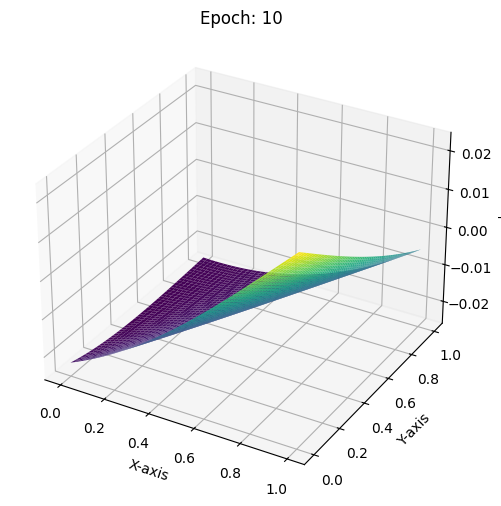

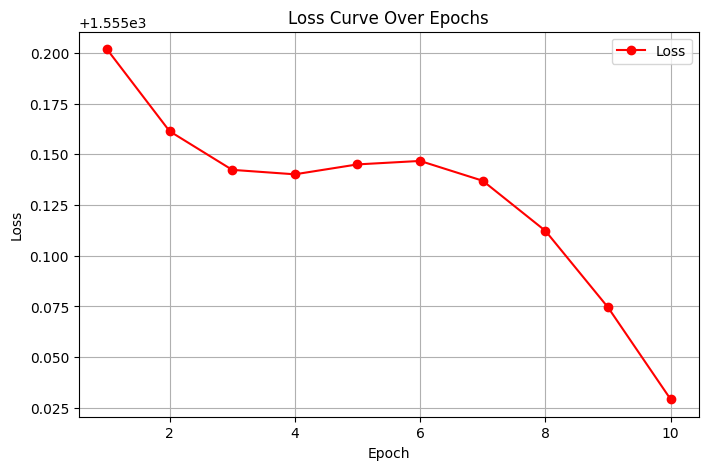

In [83]:
# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='r', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Over Epochs")
plt.legend()
plt.grid()
plt.show()

Plot the solution after every training epoch

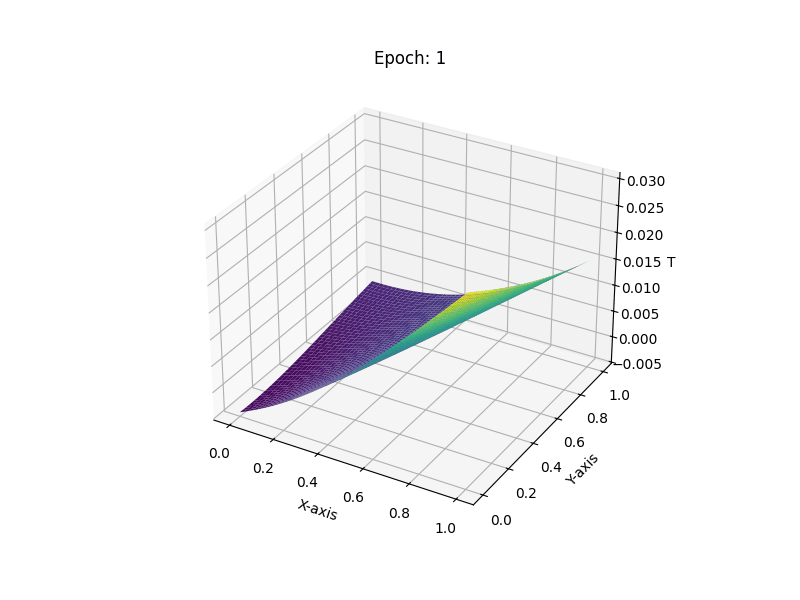

In [84]:
display(Image(filename="training_animation.gif"))

##Example 2
Heat Equation: ∂²T/∂x² + ∂²T/∂y² = 0

Initial Conditions:
T(0,y) = 0
T(1,y) = 0
T(x,0) = 0
T(x,1) = sin(πx)


##Example 3
Heat Equation: ∂²T/∂x² + ∂²T/∂y² = 0

Initial Conditions:
T(0,y) = 0
T(1,y) = y(1-y)
T(x,0) = 0
T(x,1) = 0


##Example 4
Heat Equation: ∂T/∂t = α(∂²T/∂x² + ∂²T/∂y²)

Initial Conditions:
T(x,y,0) = sin(πx)sin(πy)
T(0,y,t) = 0
T(1,y,t) = 0
T(x,0,t) = 0
T(x,1,t) = 0
α = 0.01
